In [137]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold      
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, SubsetRandomSampler     
from torch.utils.data import ConcatDataset

In [138]:
# from dataset import Fingers

import glob
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class Fingers(Dataset):

    # define constructor
    def __init__(self, directory, transform=None):
        '''
        Arguments:
        + directory (string): Directory containing image data
        + transform (callable): optional transform to apply on sample
        '''
        # directory containing the images
        self.directory = directory
        self.transform = transform
        self.glob_path = glob.glob(directory)
        self.dataset = []
        self.class_set = []
        # Images follow the pattern of <some random string>_<class>.png, we parse through the string name to extract the number of fingers in the photo.
        for img_path in self.glob_path:
            self.dataset.append(img_path)
            self.class_set.append(int(img_path[-6:-5]))
        # dataset contains paths of all the iamges
        self.dataset = np.array(self.dataset)
        

    def __len__(self):
        # length of list
        return len(self.dataset)

    def __getitem__(self, idx):
        image = read_image(self.dataset[idx], ImageReadMode.UNCHANGED).float()
        label = self.class_set[idx]

        # return image and label
        return(image, label)

In [139]:
from PIL import Image

class Digits(Dataset): # 1230 images of size '100x100'

    # define constructor
    def __init__(self, directory, transform=None):
        '''
        Arguments:
        + directory (string): Directory containing image data
        + transform (callable): optional transform to apply on sample
        '''
        # directory containing the images
        self.directory = directory
        self.transform = transform
        self.glob_path = glob.glob(directory)
        self.dataset = []
        self.class_set = []
        # Images follow the pattern of <some random string>_<class>.png, we parse through the string name to extract the number of fingers in the photo.
        for img_path in self.glob_path:
            self.dataset.append(img_path)
            self.class_set.append(int(img_path[-5:-4]))
        # dataset contains paths of all the iamges
        self.dataset = np.array(self.dataset)
        

    def __len__(self):
        # length of list
        return len(self.dataset)

    def __getitem__(self, idx):
        image = Image.open(self.dataset[idx])
        if self.transform:
            image = self.transform(image)
        label = self.class_set[idx]

        # return image and label
        return(image, label)

In [193]:
# from model import ConvNet

import torch.nn.functional as F

class ConvNet(nn.Module):
        def __init__(self):
            super(ConvNet, self).__init__()
            # Convolutional layers
            # Images are all in grayscale so only 1 colour channel
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1)
            self.bn1 = nn.BatchNorm2d(4)
            self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=1)
            self.bn2 = nn.BatchNorm2d(8)
            self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
            self.bn3 = nn.BatchNorm2d(16)
            self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1)
            self.bn4 = nn.BatchNorm2d(32)
            self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=1)
            self.bn5 = nn.BatchNorm2d(64)
            self.pool = nn.MaxPool2d(2,2)
            self.dr1 = nn.Dropout(0.5)
            self.dr2 = nn.Dropout(0.5)
            self.dr3 = nn.Dropout(0.2)
            self.dr4 = nn.Dropout(0.2)
            # Fully Connected Layers
            self.fc1 = nn.Linear(64*11*11, 100)
            self.fc2 = nn.Linear(100, 81)
            self.fc3 = nn.Linear(81, 6)


        def forward(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.dr1(x)
            x = F.relu(self.bn3(self.conv3(x)))
            x = self.dr2(x)
            x = self.pool(F.relu(self.bn4(self.conv4(x))))
            x = self.pool(F.relu(self.bn5(self.conv5(x))))

            # print(x.shape)
            # Flattening the tensor dimensions after convolutions
            x = x.view(-1, 64*11*11)
            x = F.relu(self.fc1(x))
            x = self.dr3(x)
            x = F.relu(self.fc2(x))
            x = self.dr4(x)
            x = self.fc3(x)
            return x

In [194]:
def imshow(sample_element):
    plt.imshow(sample_element[0].numpy().reshape((128, 128)), cmap='gray')
    plt.show()

In [195]:
# Hyper parameters
n_classes = 6 # Model classifications (number of fingers)

batch_s = 48 # Determines how many times the model steps through (2000, 1000, 500)
n_epochs = 5 # Determines how many times the training process loops
learning_rate = 0.0001 # Determines how much the model changes during training
mom = 0.9
# Training set consists of 18,000 images
temp_trainset = Fingers('./data/train/*.png')
temp_trainloader = DataLoader(temp_trainset, batch_size=batch_s, shuffle=False)

mean_value = 0
std_value = 0
total_images = 0
for images, _ in temp_trainloader:
    mean_value += torch.mean(images)
    std_value += torch.std(images)
    total_images += 1
mean_value /= total_images
std_value /= total_images

# print(mean_value, std_value)

# Mean, Std = tensor(63.7155) tensor(39.9851)
training = transforms.Compose([
    transforms.RandomRotation(degrees=30),              # Random rotation up to 30 degrees
    transforms.RandomHorizontalFlip(p=0.5),             # Random horizontal flip with 50% probability
    transforms.ColorJitter(brightness=0.2,               # Random color jittering
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.2),
    transforms.RandomResizedCrop(size=(128, 128),        # Random resized crop to 128x128
                                  scale=(0.8, 1.0),      # Scale range for cropping
                                  ratio=(0.75, 1.333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_value, std=std_value)
])

validation = transforms.Compose([          
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=30),              
    transforms.RandomHorizontalFlip(p=0.5),   
    transforms.RandomResizedCrop(size=(128, 128),        
                                  scale=(0.8, 1.0),      
                                  ratio=(0.75, 1.333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_value, std=std_value)
    ])

k_folds = 5
kf = KFold(n_splits=k_folds)

tensor(63.7154) tensor(39.9895)


In [196]:
# Fingers dataset consists of 21600 128x128 black & white images of left/right hands
# Each image then providing a 1x128x128 dimensional tensor

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training set consists of 18,000 images
train_dataset = Fingers('./data/train/*.png', transform=training)
# Test set consists of 2,600 images
test_dataset = Fingers('./data/test/*.png', transform=training)
# Validation set consists of 1,230 images
validation_dataset = Digits('./data/validation/*.JPG', transform=validation)

# train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)
# val_loader = DataLoader(validation_dataset, batch_size=batch_s, shuffle=True)
            
classes = ('0', '1', '2', '3', '4', '5')

In [197]:
combined_dataset = ConcatDataset([train_dataset, validation_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_s, shuffle=True)

kfolds = 5
kf = KFold(n_splits=kfolds, shuffle=True)

# all_accuracies, all_test_accuracies = []
training_loss, loss_count = [], []
avg_acc = []

for fold, (train_index, val_index) in enumerate(kf.split(combined_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    # Create DataLoader for train and validation
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_loader = DataLoader(combined_dataset, batch_size=batch_s, sampler=train_sampler)
    val_loader = DataLoader(combined_dataset, batch_size=batch_s, sampler=val_sampler)
    
    total_steps = len(train_loader)

    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=mom)

    for epoch in range(n_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # print(loss)
            # backward pass and optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            loss_count.append(loss.item())

            if (i+1) % 100 == 0:
                avg_train_loss = sum(loss_count) / len(loss_count)
                loss_count.clear()
                training_loss.append(avg_train_loss)
                print(f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}, Average Loss: {avg_train_loss:.4f}')
                # Instantaneous Loss and Average Loss over the batch is calculated
    print('Finished Training! \n')  

    # Validation
    model.eval()
    correct = 0
    total = 0 
  
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print("Test Check:")
    acc = (100 * correct / total)
    print(f'Accuracy of: {100 * correct / total:.2f} % on the Validation Set \n')
    avg_acc.append(acc)
mean_acc = 0
for i in avg_acc:
    mean_acc += i
print(f"Mean Accuracy Score: {mean_acc / len(avg_acc)}")



Fold 1/5
320
Epoch [1/5], Step [100/320], Loss: 1.6638, Average Loss: 1.7452
Epoch [1/5], Step [200/320], Loss: 1.4981, Average Loss: 1.5762
Epoch [1/5], Step [300/320], Loss: 1.3161, Average Loss: 1.3742
Epoch [2/5], Step [100/320], Loss: 0.9564, Average Loss: 1.1236
Epoch [2/5], Step [200/320], Loss: 0.7505, Average Loss: 0.8913
Epoch [2/5], Step [300/320], Loss: 0.5488, Average Loss: 0.7198
Epoch [3/5], Step [100/320], Loss: 0.4667, Average Loss: 0.5792
Epoch [3/5], Step [200/320], Loss: 0.5177, Average Loss: 0.4994
Epoch [3/5], Step [300/320], Loss: 0.3801, Average Loss: 0.4416
Epoch [4/5], Step [100/320], Loss: 0.4278, Average Loss: 0.3860
Epoch [4/5], Step [200/320], Loss: 0.2598, Average Loss: 0.3600
Epoch [4/5], Step [300/320], Loss: 0.2461, Average Loss: 0.3402
Epoch [5/5], Step [100/320], Loss: 0.2575, Average Loss: 0.3312
Epoch [5/5], Step [200/320], Loss: 0.2174, Average Loss: 0.3011
Epoch [5/5], Step [300/320], Loss: 0.1942, Average Loss: 0.2861
Finished Training! 

Size o

Network with learning rate of 0.0001 over 5 epochs results in accuracy of: 93.19444444444444 % on the Test set
Accuracy of 0 fingers: 100.0000 %
Accuracy of 1 fingers: 85.9155 %
Accuracy of 2 fingers: 95.8904 %
Accuracy of 3 fingers: 77.6471 %
Accuracy of 4 fingers: 100.0000 %
Accuracy of 5 fingers: 100.0000 %


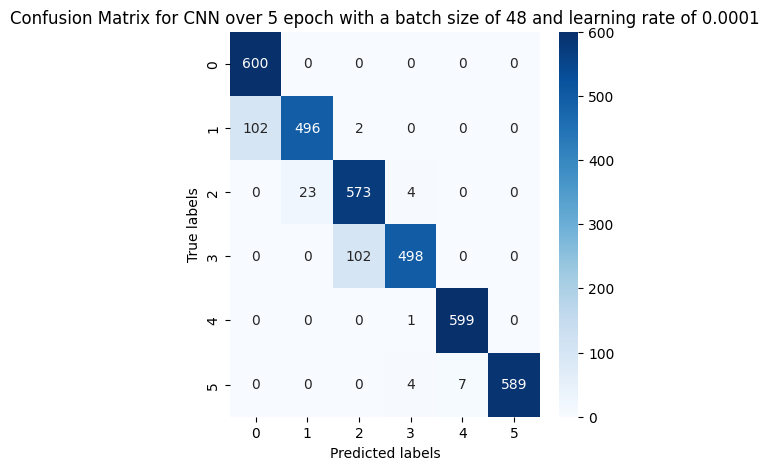

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       600
           1       0.96      0.83      0.89       600
           2       0.85      0.95      0.90       600
           3       0.98      0.83      0.90       600
           4       0.99      1.00      0.99       600
           5       1.00      0.98      0.99       600

    accuracy                           0.93      3600
   macro avg       0.94      0.93      0.93      3600
weighted avg       0.94      0.93      0.93      3600



In [199]:
# Tracking preds and labels
all_predictions = []
all_labels = []

with torch.no_grad(): # Don't need backward propagation and gradient calculations
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(6):
            label = labels[i]
            pred = predicted[i]
            if (label == pred): 
                n_class_correct[label] += 1
            n_class_samples[label] += 1

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
confusion_m = confusion_matrix(all_labels, all_predictions)

accuracy = 100.0 * n_correct / n_samples
print(f'Network with learning rate of {learning_rate} over {n_epochs} epochs results in accuracy of: {accuracy} % on the Test set')
                    
for i in range(n_classes):
    if n_class_samples[i] != 0:
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
    else:
        accuracy = 'NaN'

    print(f'Accuracy of {classes[i]} fingers: {accuracy:.4f} %')

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_m, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix for CNN over {n_epochs} epoch with a batch size of {batch_s} and learning rate of {learning_rate}')
plt.show()

classification_rep = classification_report(all_labels, all_predictions)
print(classification_rep)